In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import plotly.express as px
import calendar
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = file = pd.read_csv("National_Interagency_Fire_Occurrence_Sixth_Edition_1992-2020_(Feature_Layer).csv")

# Cleaning and EDA

In [3]:
# Create copy to avoid tampering with original data
df = data.copy()
print(df.info())
# Turn Fire Size from object type to numeric
df['FIRE_SIZE'] = pd.to_numeric(df['FIRE_SIZE'], errors='coerce')
# Turn Dates into datetime objects
df["DISCOVERY_DATE"] = pd.to_datetime(df["DISCOVERY_DATE"], utc=True)
df["CONT_DATE"] = pd.to_datetime(df["CONT_DATE"], utc=True)
df.dropna(subset=["CONT_DATE"], inplace=True, axis=0)
df["CONT_LEN"] = df["CONT_DATE"] - df["DISCOVERY_DATE"]
df["CONT_DAYS"] = (df["CONT_LEN"].dt.days + 1)
#Some cont_date is NA, so CONT_DAYS would be NA but since we want to use this
df["FIRE_SIZE_CLASS"].astype("str")
# Grab the int associated with each month
df["DISC_MONTH"] = df["DISCOVERY_DATE"].dt.month
# Grab the int associated with each day of the week
df["DISC_DAY"] = df["DISCOVERY_DATE"].dt.day_of_week
# Create a column that tracks fires over 500
df['OVER_500'] = (df['FIRE_SIZE'] >= 500).astype(int)
df.drop([ "FIRE_NAME", "X", "Y", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME",  "SOURCE_REPORTING_UNIT_NAME", "LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID", "FIRE_CODE", "ICS_209_PLUS_INCIDENT_JOIN_ID", "ICS_209_PLUS_COMPLEX_JOIN_ID", "MTBS_ID", "MTBS_FIRE_NAME", "COMPLEX_NAME", "FIPS_CODE", "FIPS_NAME", "OBJECTID", "FOD_ID", "FPA_ID", "SOURCE_SYSTEM",  "COUNTY"], axis=1, inplace=True)
df.drop(df[df['NWCG_CAUSE_CLASSIFICATION'] == 'Missing data/not specified/undetermined' ].index, inplace=True)
df.drop(df[df["NWCG_GENERAL_CAUSE"] == 'Missing data/not specified/undetermined' ].index, inplace=True)
states_dict = {
    'West': ['CA', 'OR', 'WA', 'AK', 'HI', 'MT', 'ID', 'WY', 'CO', 'UT', 'NV', 'AZ', 'NM'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'GA', 'FL', 'SC', 'NC', 'VA', 'WV', 'DC'],
    'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'ME', 'MD', 'DE', 'VT'],
    'Territories': ['PR']
}
# Seperate into regions and add new column
def region(state):
    for region, states in states_dict.items():
        if state in states:
            return region
df["REGION"] = df["STATE"].apply(region)
# Summarize causes
causes_dict = {
    "Natural": ["Natural"],
    "Illegal": ["Arson/incendiarism", "Firearms and explosives use"],
    "Infastructure": ["Railroad operations and maintenance", "Equipment and vehicle use", "Power generation/transmission/distribution"],
    "Accidental" : ["Misuse of fire by a minor", "Smoking", "Recreation and ceremony", "Fireworks", "Debris and open burning"],
    "Others": ["Other causes"]
}
def causes(cause):
    for label, causes in causes_dict.items():
        if cause in causes:
            return label
df["CAUSE_CLASS"] = df["NWCG_GENERAL_CAUSE"].apply(causes)
df['OVER_500'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303566 entries, 0 to 2303565
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   X                              float64
 1   Y                              float64
 2   OBJECTID                       int64  
 3   FOD_ID                         int64  
 4   FPA_ID                         object 
 5   SOURCE_SYSTEM_TYPE             object 
 6   SOURCE_SYSTEM                  object 
 7   NWCG_REPORTING_AGENCY          object 
 8   NWCG_REPORTING_UNIT_ID         object 
 9   NWCG_REPORTING_UNIT_NAME       object 
 10  SOURCE_REPORTING_UNIT          object 
 11  SOURCE_REPORTING_UNIT_NAME     object 
 12  LOCAL_FIRE_REPORT_ID           object 
 13  LOCAL_INCIDENT_ID              object 
 14  FIRE_CODE                      object 
 15  FIRE_NAME                      object 
 16  ICS_209_PLUS_INCIDENT_JOIN_ID  object 
 17  ICS_209_PLUS_COMPLEX_JOIN_ID   object 
 18  MT

OVER_500
0    1076286
1      14243
Name: count, dtype: int64

In [4]:
summary = df.groupby('FIRE_YEAR').agg(
    total_acres_burned=('FIRE_SIZE', 'sum'),
    number_of_fires=('FIRE_SIZE', 'count'),
    average_fire_size=('FIRE_SIZE', 'mean'),
    fires_over_500_acres=('FIRE_SIZE', lambda x: (x > 500).sum())
).reset_index()

worst_by_acres = summary.sort_values('total_acres_burned', ascending=False).iloc[0]
worst_by_large_fires = summary.sort_values('fires_over_500_acres', ascending=False).iloc[0]

print("Worst fire season by total acres burned:")
print(worst_by_acres)

print("Worst fire season by number of fires over 500 acres:")
print(worst_by_large_fires)


Worst fire season by total acres burned:
FIRE_YEAR               2.015000e+03
total_acres_burned      8.516033e+06
number_of_fires         4.431100e+04
average_fire_size       1.921878e+02
fires_over_500_acres    5.810000e+02
Name: 23, dtype: float64
Worst fire season by number of fires over 500 acres:
FIRE_YEAR               2.006000e+03
total_acres_burned      6.786308e+06
number_of_fires         4.472200e+04
average_fire_size       1.517443e+02
fires_over_500_acres    8.720000e+02
Name: 14, dtype: float64


In [5]:
# I wanted to study fire seasons with the larges fires over 20 acres
df_six = df[df["FIRE_YEAR"] == 2006]
df_six = df_six[df_six["FIRE_SIZE"] > 20]



In [6]:
df_six.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 2258 to 1720704
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   SOURCE_SYSTEM_TYPE         5329 non-null   object             
 1   NWCG_REPORTING_AGENCY      5329 non-null   object             
 2   SOURCE_REPORTING_UNIT      5329 non-null   object             
 3   FIRE_YEAR                  5329 non-null   int64              
 4   DISCOVERY_DATE             5329 non-null   datetime64[ns, UTC]
 5   DISCOVERY_DOY              5329 non-null   int64              
 6   DISCOVERY_TIME             5128 non-null   float64            
 7   NWCG_CAUSE_CLASSIFICATION  5329 non-null   object             
 8   NWCG_GENERAL_CAUSE         5329 non-null   object             
 9   NWCG_CAUSE_AGE_CATEGORY    64 non-null     object             
 10  CONT_DATE                  5329 non-null   datetime64[ns, UTC]
 11  CON

In [7]:
df_six.describe()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,CONT_LEN,CONT_DAYS,DISC_MONTH,DISC_DAY,OVER_500
count,5329.0,5329.000000,5128.000000,5329.000000,5013.000000,5329.000000,5329.000000,5329.000000,5329,5329.000000,5329.000000,5329.000000,5329.000000
mean,2006.0,153.022331,1442.303627,157.042034,1623.308398,1258.002112,36.443163,-99.382257,4 days 00:28:22.383186338,5.019704,5.577031,2.968850,0.166448
std,0.0,79.659399,410.949055,83.174782,466.447774,8540.869633,5.601702,13.317765,13 days 23:34:03.939932239,13.981990,2.599110,2.056851,0.372517
min,2006.0,1.000000,0.000000,1.000000,0.000000,20.100000,25.288496,-163.750000,0 days 00:00:00,1.000000,1.000000,0.000000,0.000000
25%,2006.0,85.000000,1234.000000,86.000000,1415.000000,35.000000,32.672780,-112.359444,0 days 00:00:00,1.000000,3.000000,1.000000,0.000000
50%,2006.0,166.000000,1449.500000,168.000000,1730.000000,70.000000,35.255000,-96.142200,0 days 00:00:00,1.000000,6.000000,3.000000,0.000000
75%,2006.0,210.000000,1700.000000,217.000000,1915.000000,234.000000,40.350000,-87.416018,2 days 00:00:00,3.000000,7.000000,5.000000,0.000000
max,2006.0,364.000000,2359.000000,365.000000,2359.000000,238462.600000,68.115000,-67.062750,178 days 00:00:00,179.000000,12.000000,6.000000,1.000000


In [8]:
df_six.sample(n=20)

,SOURCE_SYSTEM_TYPE,NWCG_REPORTING_AGENCY,SOURCE_REPORTING_UNIT,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,NWCG_CAUSE_AGE_CATEGORY,...,LONGITUDE,OWNER_DESCR,STATE,CONT_LEN,CONT_DAYS,DISC_MONTH,DISC_DAY,OVER_500,REGION,CAUSE_CLASS
617247,NONFED,ST/C&L,TXWZS,2006,2006-03-09 00:00:00+00:00,68,1000.0,Human,Debris and open burning,NaN,...,-98.990910,PRIVATE,TX,0 days,1,3,3,0,South,Accidental
1133594,NONFED,ST/C&L,CARRU,2006,2006-06-03 00:00:00+00:00,154,1645.0,Human,Equipment and vehicle use,NaN,...,-117.093889,MISSING/NOT SPECIFIED,CA,1 days,2,6,5,0,West,Infastructure
618879,NONFED,ST/C&L,TXLAS,2006,2006-06-12 00:00:00+00:00,163,1300.0,Natural,Natural,NaN,...,-94.605280,PRIVATE,TX,0 days,1,6,0,0,South,Natural
10223,FED,FS,108,2006,2006-07-06 00:00:00+00:00,187,1100.0,Natural,Natural,NaN,...,-108.959722,MISSING/NOT SPECIFIED,MT,3 days,4,7,3,1,West,Natural
561565,NONFED,ST/C&L,NMNMS,2006,2006-05-22 00:00:00+00:00,142,1105.0,Natural,Natural,NaN,...,-103.925600,MISSING/NOT SPECIFIED,NM,0 days,1,5,0,0,West,Natural
337500,FED,BLM,NVWID,2006,2006-07-12 00:00:00+00:00,193,130.0,Natural,Natural,NaN,...,-118.329400,BLM,NV,0 days,1,7,2,0,West,Natural
1159438,NONFED,ST/C&L,ALDDV,2006,2006-03-01 00:00:00+00:00,60,1626.0,Human,Arson/incendiarism,NaN,...,-85.474574,MISSING/NOT SPECIFIED,AL,0 days,1,3,2,0,South,Illegal
17650,FED,FS,512,2006,2006-07-09 00:00:00+00:00,190,833.0,Natural,Natural,NaN,...,-116.766667,USFS,CA,62 days,63,7,6,1,West,Natural
1159598,NONFED,ST/C&L,ALMGM,2006,2006-03-13 00:00:00+00:00,72,2050.0,Human,Arson/incendiarism,NaN,...,-85.138995,MISSING/NOT SPECIFIED,AL,1 days,2,3,0,0,South,Illegal
308451,FED,BLM,AZPHD,2006,2006-08-21 00:00:00+00:00,233,2100.0,Natural,Natural,NaN,...,-113.362700,BLM,AZ,8 days,9,8,0,0,West,Natural


# EDA With Columns I'll be using

### Natural vs Human

Text(0.5, 1.0, 'Human vs Natural causes')

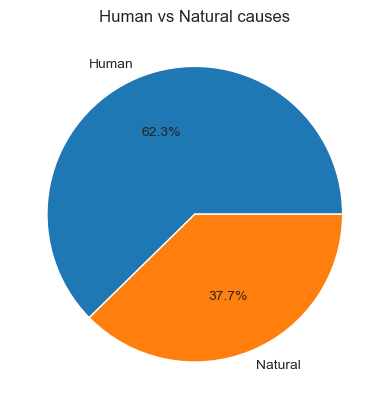

In [9]:
classifications = df_six["NWCG_CAUSE_CLASSIFICATION"].value_counts()
sns.set_style('darkgrid')
plt.pie(classifications, labels=["Human", "Natural"], autopct='%1.1f%%')

plt.title("Human vs Natural causes")

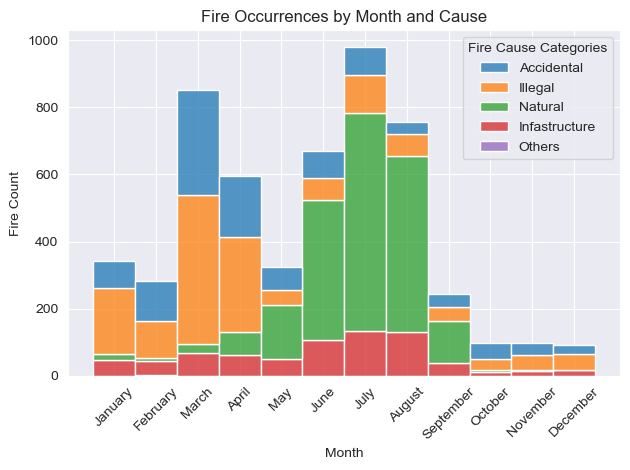

In [10]:
# Plot using histplot for grouped bar effect
sns.set_style('darkgrid')
sns.histplot(data=df_six, x='DISC_MONTH', hue='CAUSE_CLASS', multiple='stack', bins=12, discrete=True)
# Set x-axis labels to month names
plt.xticks(ticks=range(1, 13), labels=calendar.month_name[1:], rotation=45)
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.title('Fire Occurrences by Month and Cause')
legend = plt.gca().get_legend()
legend.set_title("Fire Cause Categories")
plt.tight_layout()
plt.show()

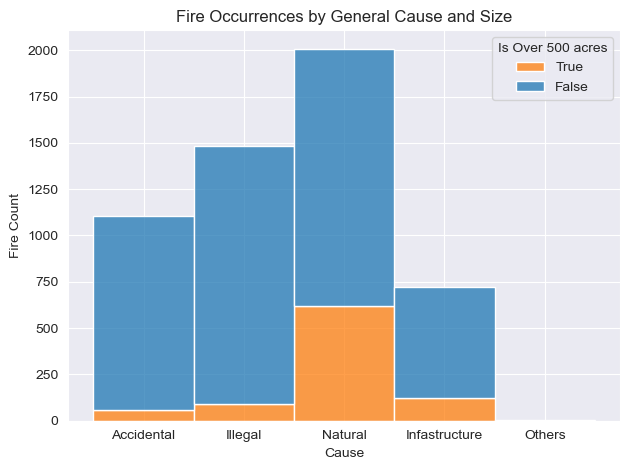

In [11]:
sns.histplot(data=df_six, x='CAUSE_CLASS', hue='OVER_500', multiple='stack', discrete=True)
plt.legend(title="Is Over 500 acres", labels=["True", "False"])
plt.xlabel('Cause')
plt.ylabel('Fire Count')
plt.title('Fire Occurrences by General Cause and Size')
plt.tight_layout()
plt.show()



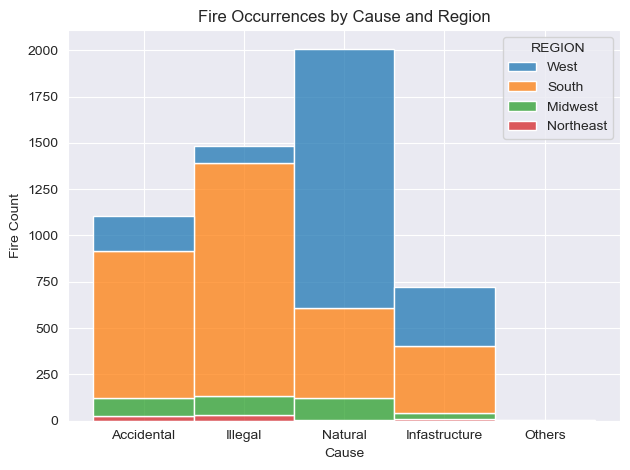

In [12]:
#d = df_six["CAUSE_CLASS"].sort_values(ascending=False).value_counts()
#d.plot.bar()
#plt.show()
sns.histplot(data=df_six, x='CAUSE_CLASS', hue='REGION', multiple='stack', discrete=True)
# Set x-axis labels to month names


plt.xlabel('Cause')
plt.ylabel('Fire Count')
plt.title('Fire Occurrences by Cause and Region')

plt.tight_layout()
plt.show()



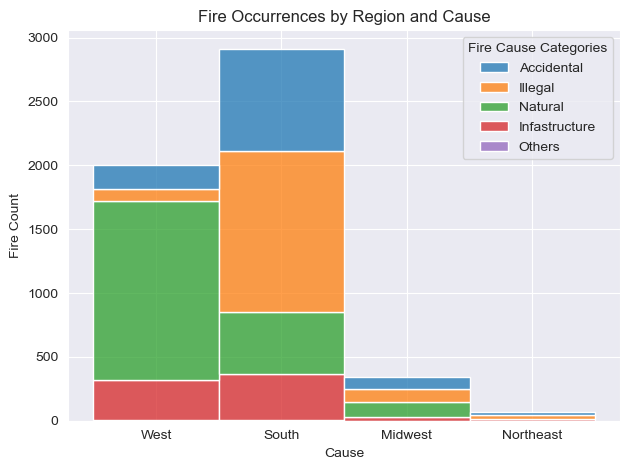

In [ ]:
sns.histplot(data=df_six, x='REGION', hue='CAUSE_CLASS', multiple='stack', discrete=True)
legend = plt.gca().get_legend()
legend.set_title("Fire Cause Categories")
plt.xlabel('Cause')
plt.ylabel('Fire Count')
plt.title('Fire Occurrences by Region and Cause')
plt.tight_layout()
plt.show()



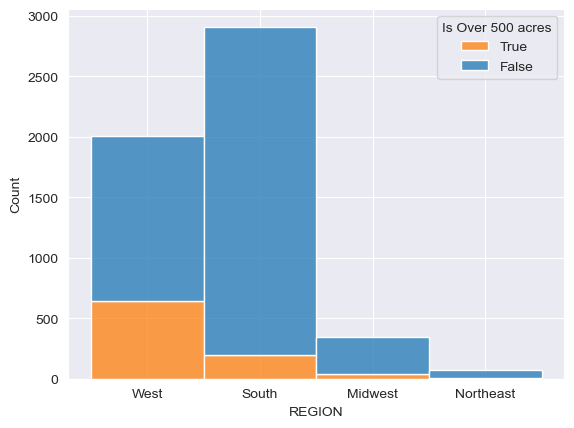

In [14]:
sns.histplot(data=df_six, x='REGION', hue='OVER_500', multiple='stack', discrete=True)
plt.legend(title="Is Over 500 acres", labels=["True", "False"])

# Predicting Whether Natural or Human Caused Fire

Accuracy: 0.8824265165728581
Precision: 0.882775008012921
Recall: 0.8824265165728581


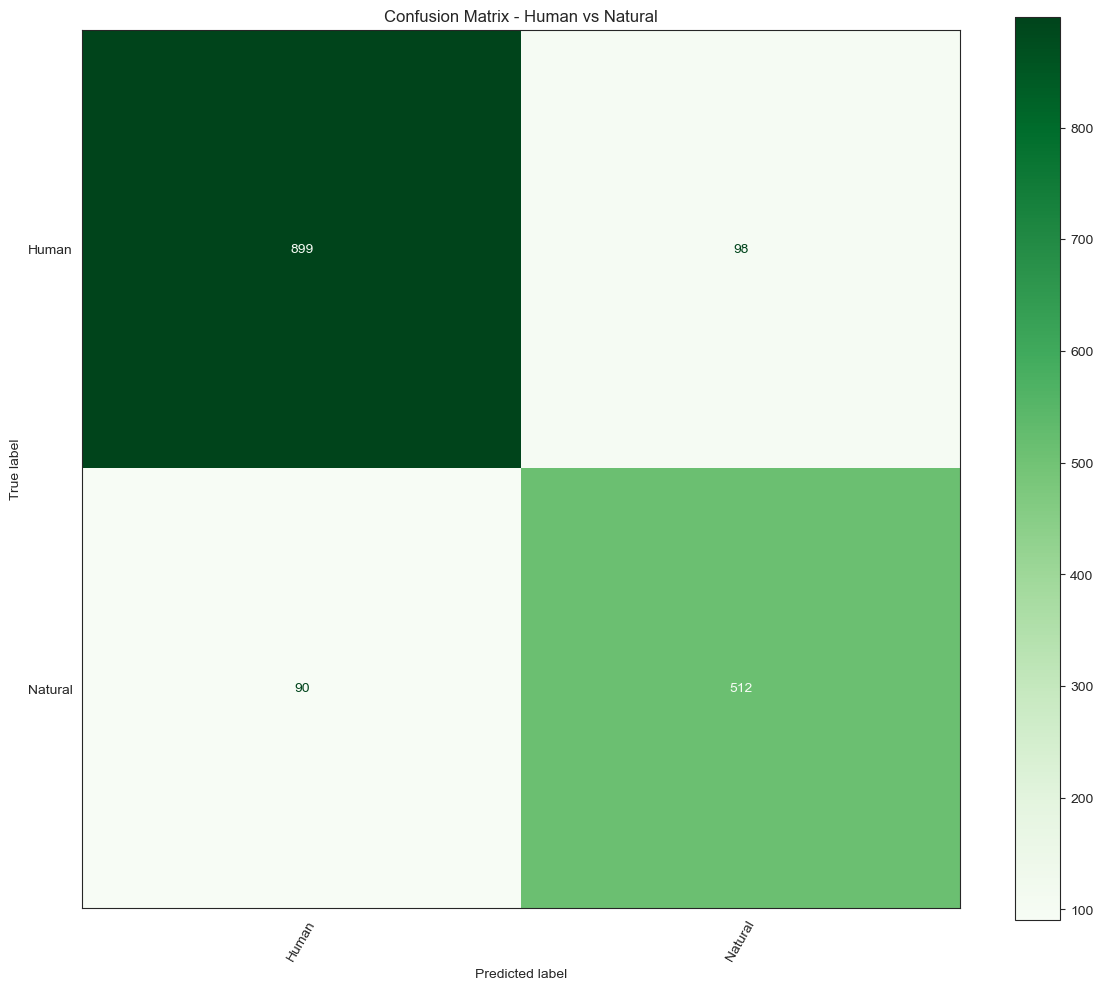

In [15]:
feature = [ 'FIRE_SIZE', 'LATITUDE','LONGITUDE', 'CONT_DAYS', 'DISC_MONTH', "REGION"]
classes = df_six.copy()
le = LabelEncoder()
X = classes[feature]
classes["Class"]  = le.fit_transform(classes["NWCG_CAUSE_CLASSIFICATION"] )
y = classes['Class']

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
cm = confusion_matrix(y_test, y_pred)
sns.set_style("white")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust size if needed
disp.plot(xticks_rotation=60, ax=ax, cmap='Greens')
plt.title('Confusion Matrix - Human vs Natural')
plt.tight_layout()
plt.show()




In [16]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34bdfb0e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34bec78c0>})

In [17]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 163}


In [18]:
y_pred = best_rf.predict(X_test)

Accuracy: 0.8805503439649781
Precision: 0.881275707532526
Recall: 0.8805503439649781
F1-Score: 0.8808325785683461
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       997
           1       0.83      0.85      0.84       602

    accuracy                           0.88      1599
   macro avg       0.87      0.88      0.87      1599
weighted avg       0.88      0.88      0.88      1599



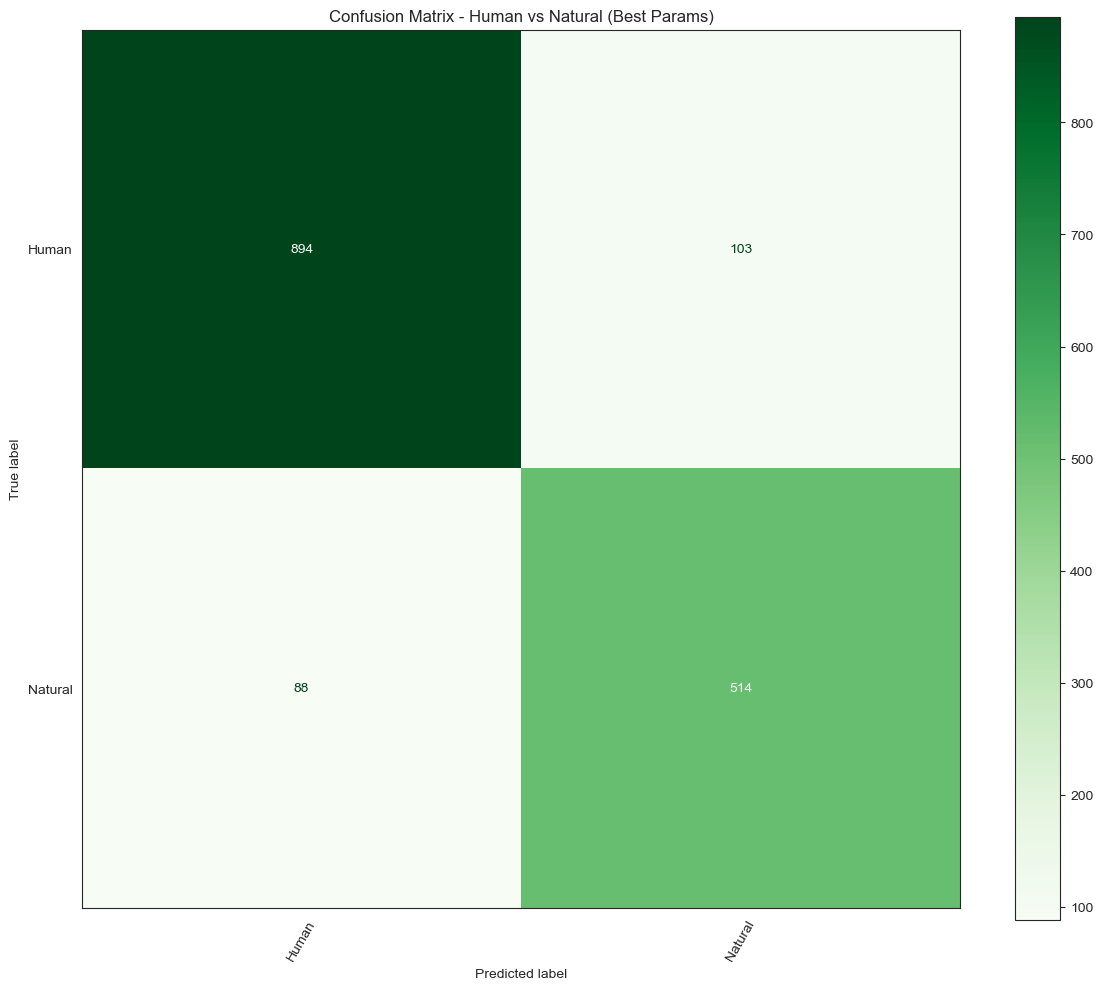

In [19]:
cm = confusion_matrix(y_test, y_pred)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1score = f1_score(y_test, y_pred, average="weighted" )

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1score)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10)) 
disp.plot(xticks_rotation=60, ax=ax, cmap='Greens')
plt.title('Confusion Matrix - Human vs Natural (Best Params)')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Feature Importance - Human vs Natural')

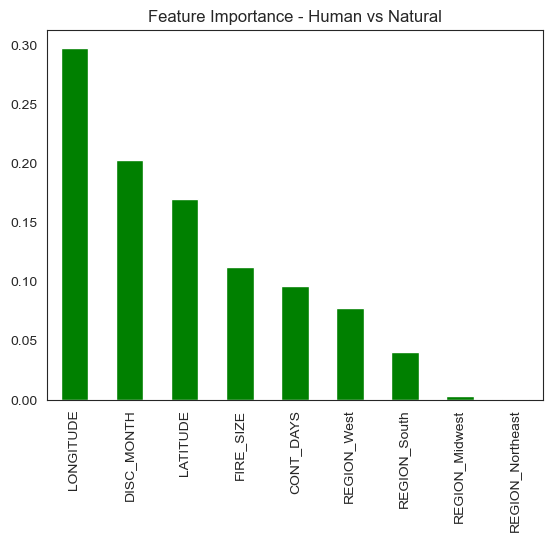

In [20]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar(color="g")
plt.title("Feature Importance - Human vs Natural")

# Predicting Specific Causes

0.6529080675422139
              precision    recall  f1-score   support

           0       0.49      0.42      0.45       332
           1       0.62      0.70      0.65       446
           2       0.49      0.33      0.39       217
           3       0.79      0.86      0.83       602
           4       0.00      0.00      0.00         2

    accuracy                           0.65      1599
   macro avg       0.48      0.46      0.47      1599
weighted avg       0.64      0.65      0.64      1599



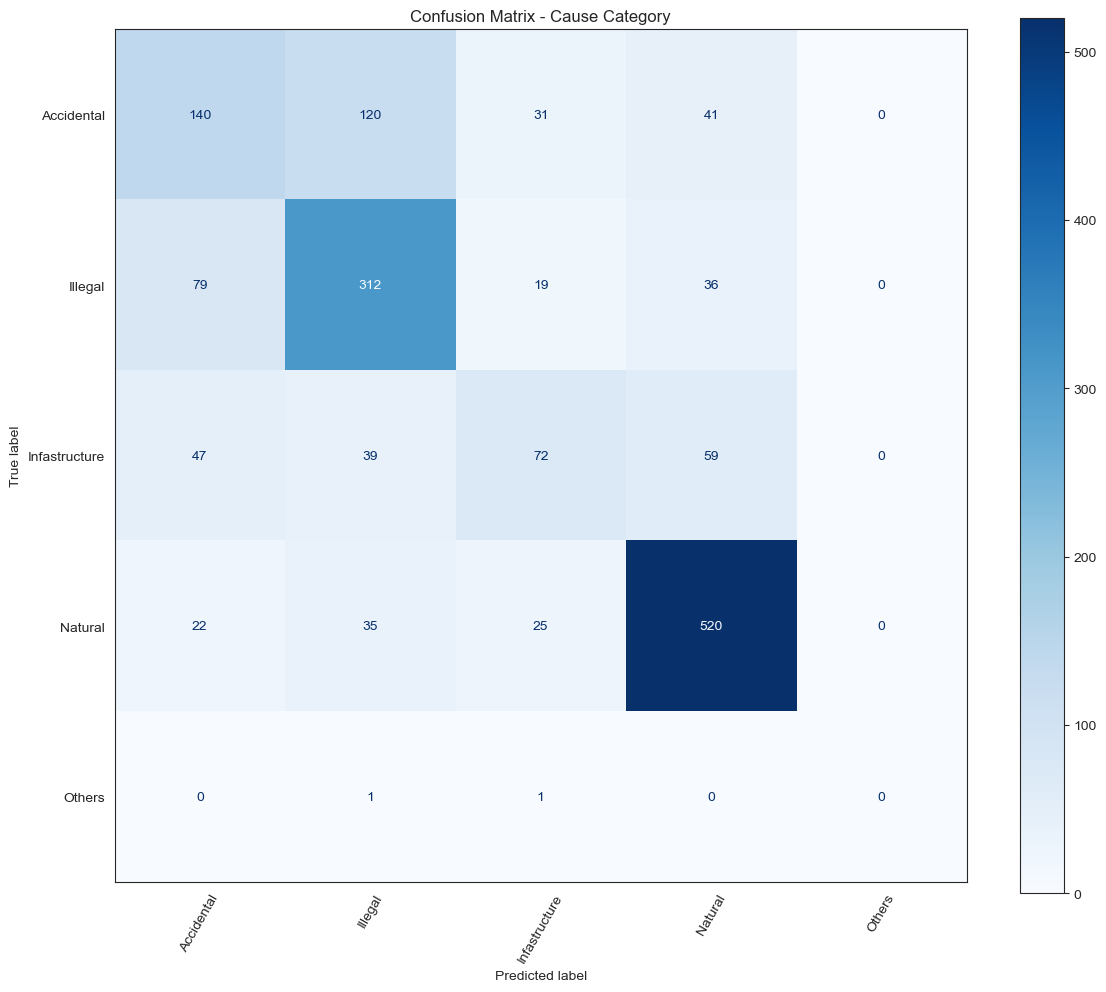

In [21]:
feature = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'CONT_DAYS', 'DISC_MONTH', "REGION"]
new_feature = df_six.copy()
X = new_feature[feature]
new_feature["Cause"]  = le.fit_transform(new_feature["CAUSE_CLASS"] )
y = new_feature['Cause']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust size if needed
disp.plot(xticks_rotation=60, ax=ax, cmap='Blues')
plt.title('Confusion Matrix - Cause Category')
plt.tight_layout()
plt.show()

In [22]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34cc5e8d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34bd66660>})

In [23]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 309}


In [24]:
y_pred = best_rf.predict(X_test)

Accuracy: 0.6591619762351469
Precision: 0.6460643379557918
Recall: 0.6591619762351469
F1-Score 0.6442990055704076
              precision    recall  f1-score   support

           0       0.54      0.38      0.44       332
           1       0.59      0.75      0.66       446
           2       0.53      0.36      0.43       217
           3       0.79      0.86      0.82       602
           4       0.00      0.00      0.00         2

    accuracy                           0.66      1599
   macro avg       0.49      0.47      0.47      1599
weighted avg       0.65      0.66      0.64      1599



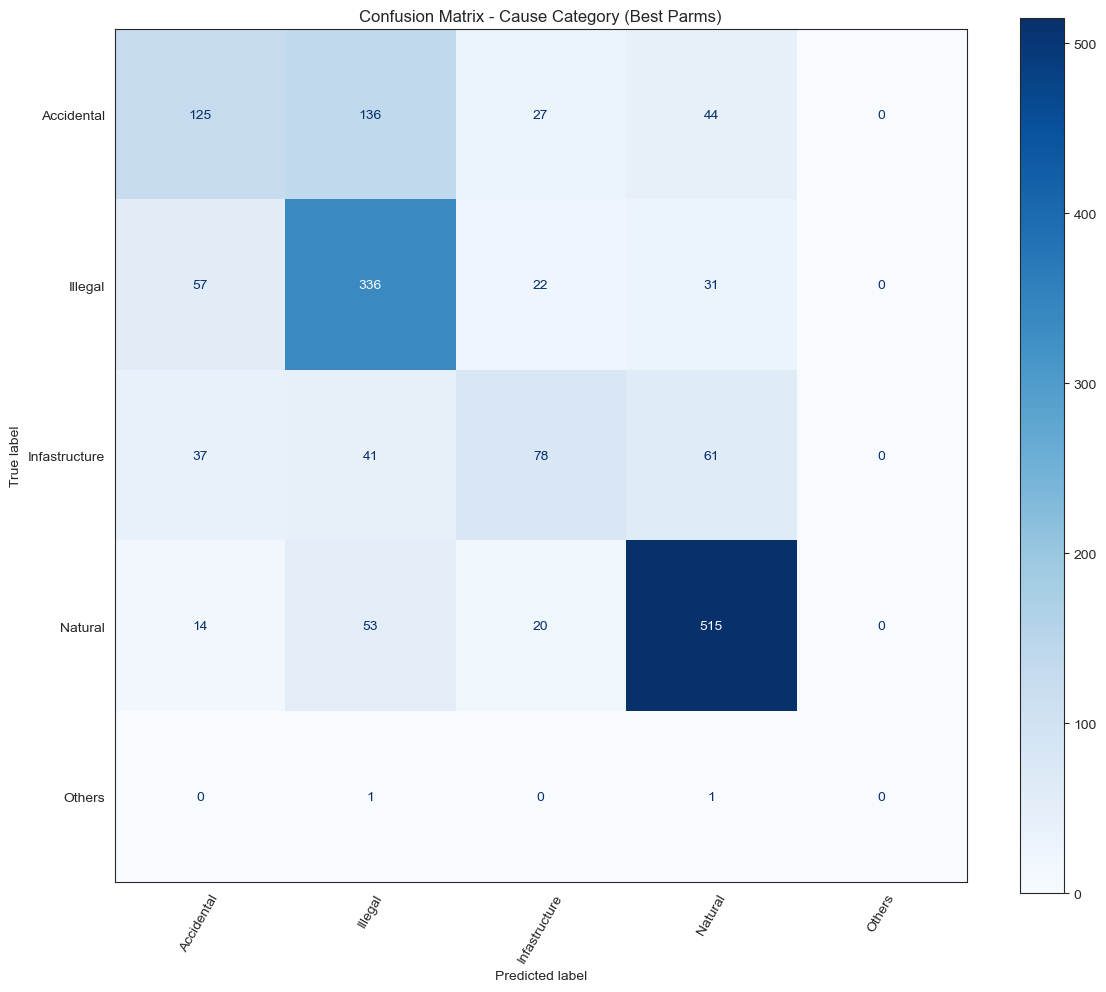

In [25]:
cm = confusion_matrix(y_test, y_pred)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1score = f1_score(y_test, y_pred, average="weighted" )
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score", f1score)

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10)) 
disp.plot(xticks_rotation=60, ax=ax, cmap='Blues')
plt.title('Confusion Matrix - Cause Category (Best Parms)')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance - Cause Category')

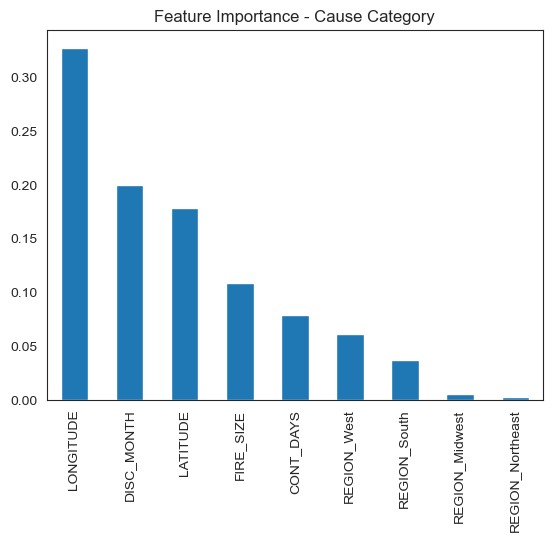

In [26]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();
plt.title("Feature Importance - Cause Category")

# Regions

For both of these, longitude is either the first or second important feature to determine the causes. This makes me think that fires might gather in the west, verses spreading across the state. Another reason for this could be the massive fires in alaska being largely related to the longitude of the state

0.7429643527204502
              precision    recall  f1-score   support

           0       0.15      0.09      0.11       104
           1       0.22      0.10      0.13        21
           2       0.78      0.84      0.81       873
           3       0.76      0.74      0.75       601

    accuracy                           0.74      1599
   macro avg       0.48      0.44      0.45      1599
weighted avg       0.72      0.74      0.73      1599



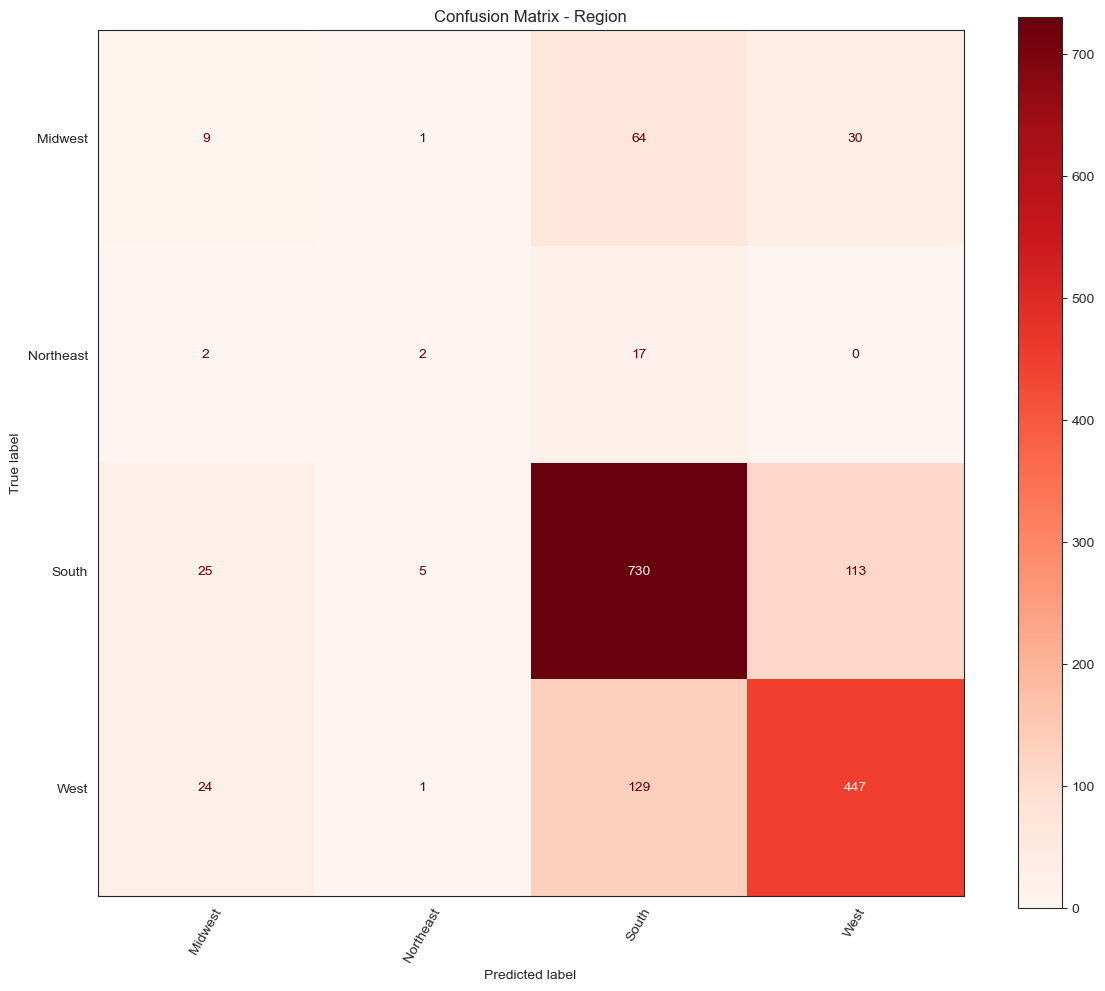

In [28]:
feature = ['FIRE_SIZE',  'CONT_DAYS',  'CAUSE_CLASS', 'DISC_MONTH' , "NWCG_CAUSE_AGE_CATEGORY"]
new_feature = df_six.copy()
X = new_feature[feature]
new_feature["Region"]  = le.fit_transform(new_feature["REGION"] )
y = new_feature['Region']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust size if needed
disp.plot(xticks_rotation=60, ax=ax, cmap='Reds')
plt.title('Confusion Matrix - Region')
plt.tight_layout()
plt.show()

In [29]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34c951ee0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34bd00b30>})

In [30]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 304}


In [31]:
y_pred = best_rf.predict(X_test)

Accuracy: 0.7848655409631019
Precision: 0.7565539529082314
Recall: 0.7848655409631019
F1-Score: 0.7550292574609685
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       104
           1       0.00      0.00      0.00        21
           2       0.80      0.87      0.83       873
           3       0.77      0.82      0.80       601

    accuracy                           0.78      1599
   macro avg       0.52      0.43      0.42      1599
weighted avg       0.76      0.78      0.76      1599



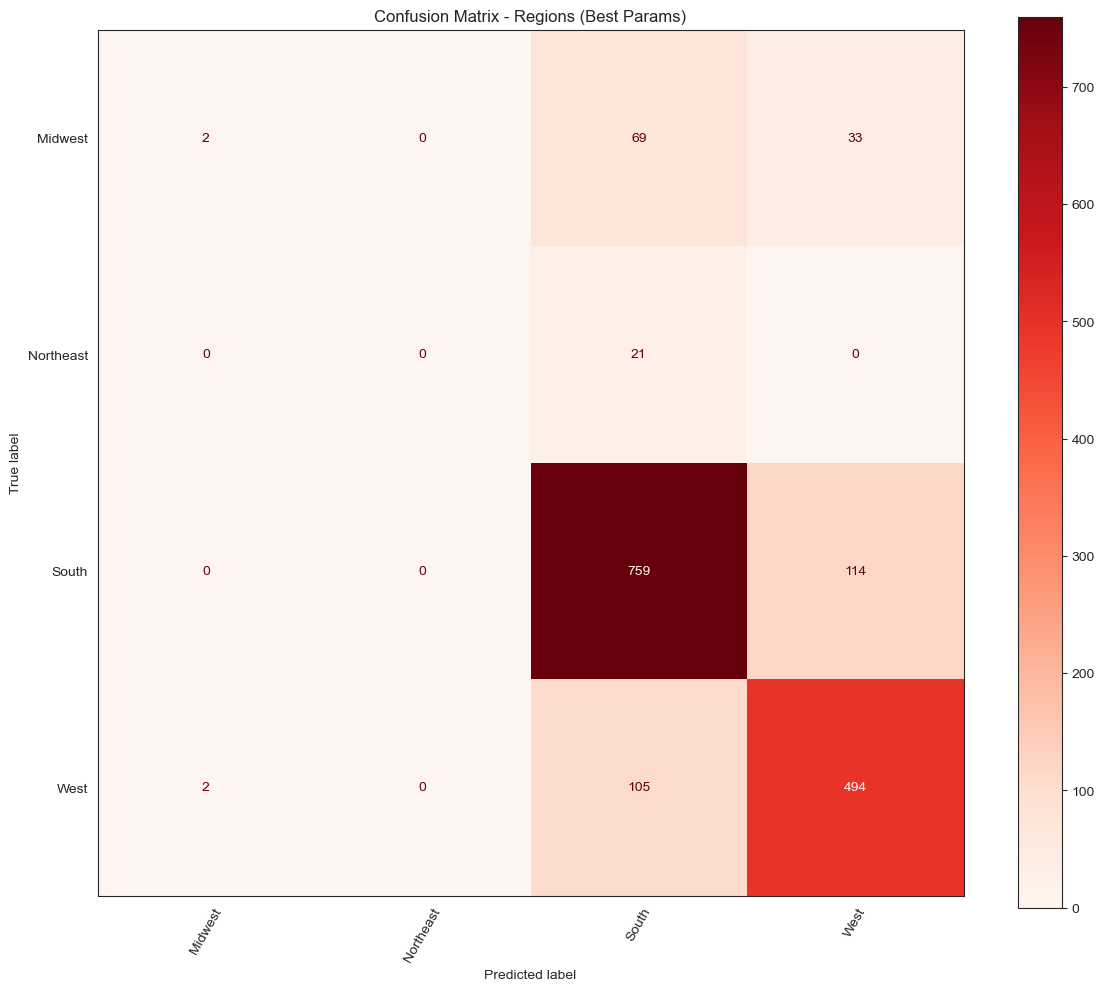

In [32]:
cm = confusion_matrix(y_test, y_pred)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
f1score = f1_score(y_test, y_pred, average="weighted" )
print("F1-Score:", f1score)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform(np.arange(y.nunique())))
fig, ax = plt.subplots(figsize=(12, 10)) 
disp.plot(xticks_rotation=60, ax=ax, cmap='Reds')
plt.title('Confusion Matrix - Regions (Best Params)')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance - Region')

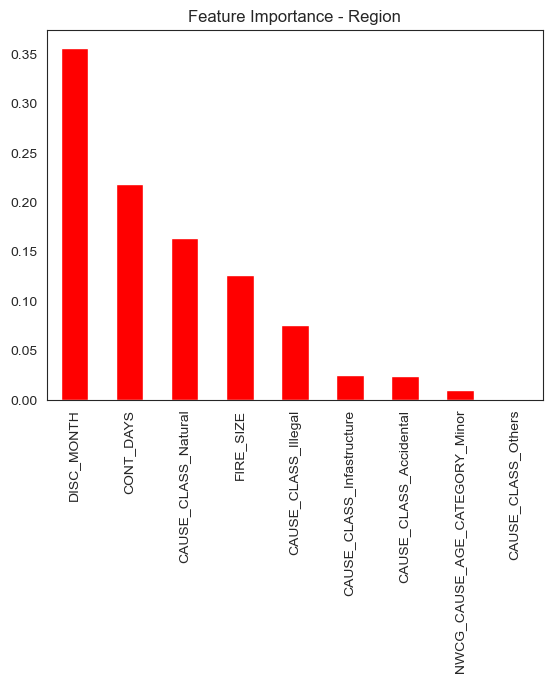

In [33]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar(color="r");
plt.title("Feature Importance - Region")

# Other Visualization

In [ ]:
df = df.sort_values('FIRE_YEAR')
df = df[df["FIRE_SIZE"] >= 500]
df['FIRE_YEAR'] = df['FIRE_YEAR'].astype(str)
fig = px.scatter_mapbox(
    df,
    lat="LATITUDE",
    lon="LONGITUDE",
    color="CAUSE_CLASS",
    size="FIRE_SIZE",
    animation_frame="FIRE_YEAR",
    mapbox_style="carto-positron",
    size_max=28,
    zoom=3, 
    center={"lat": 37.5, "lon": -95},
    title="Wildfire Causes and Sizes Over Time (Fires over 500 acres)"
)

fig.update_layout(
    width=1000,
    height=700
)

fig.show()


In [38]:

import plotly.express as px
df_six['DISC_MONTH'] = df_six['DISC_MONTH'].astype(int)
df_six = df_six.sort_values('DISC_MONTH')

fig = px.scatter_mapbox(
    df_six,
    lat="LATITUDE",
    lon="LONGITUDE",
    color="CAUSE_CLASS",
    size= "FIRE_SIZE",
    animation_frame="DISC_MONTH",
    mapbox_style="carto-positron",
    center={"lat": 37.5, "lon": -95},
    size_max=32,
    zoom=3, 
    title="Wildfire Causes and Sizes in 2006 over a Year"
)
fig.update_layout(
    width=1000,
    height=700
)
fig.show()